# Cell 1: Imports and Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from torchvision import transforms
from torch.amp import autocast
from tqdm import tqdm
from argparse import Namespace

# Import your custom modules
from networks.autoencoderkl_maisi import AutoencoderKlMaisi
from scripts.sample import ReconModel
from scripts.utils_data import split_grayscale_to_channels
from scripts.utils import define_instance

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/mhuber/miniconda3/envs/ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
import matplotlib.pyplot as plt
import torch

def plot_tensor(tensor, title="Tensor Visualization"):
    """
    Plot a (c, 4, 64, 64) tensor
    """
    c, channels, h, w = tensor.shape
    
    fig, axes = plt.subplots(c, channels, figsize=(channels*3, c*3))
    if c == 1:
        axes = axes.reshape(1, -1)
    
    for batch_idx in range(c):
        for ch_idx in range(channels):
            ax = axes[batch_idx, ch_idx]
            im = ax.imshow(tensor[batch_idx, ch_idx].detach().cpu().numpy(), 
                          cmap='viridis', aspect='auto')
            ax.set_title(f'Batch {batch_idx}, Ch {ch_idx}')
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [3]:
image_path = "/home/mhuber/Thesis/data/KermanyV3_resized/test/3/NORMAL-1569-2.jpeg"
# image_path = /home/mhuber/Thesis/data/RETOUCH/retouch_masks
mask_path = "/home/mhuber/Thesis/data/RETOUCH/retouch_masks/1.png"
eta = 0

# Cell 2: Load Configuration and Models

In [4]:
# def load_models(config_path="./configs/config_CONTROLNET_germany.json"):
def load_models(config_path="./configs/config_CONTROLNET_germany_ddim.json"):
# def load_models(config_path="./configs/config_CONTROLNET_germany_ddim_hacked.json"):
    """Load VAE, UNet, and ControlNet models"""
    
    # Load configuration
    with open(config_path, "r") as f:
        config = json.load(f)
    
    # Create args object
    args = Namespace()
    for section in ["environment", "model_def", "training", "model"]:
        if section in config:
            for k, v in config[section].items():
                setattr(args, k, v)
    
    # Load VAE (Autoencoder)
    print("Loading VAE...")
    model_config = config["model"]["autoencoder"]
    vae = AutoencoderKlMaisi(**model_config).to(device)
    
    vae_checkpoint = torch.load(args.trained_autoencoder_path, map_location=device, weights_only=True)
    vae.load_state_dict(vae_checkpoint["autoencoder_state_dict"])
    vae.eval()
    
    # Convert to float32
    for param in vae.parameters():
        param.data = param.data.to(torch.float32)
    
    # Load UNet
    print("Loading UNet...")
    unet = define_instance(args, "diffusion_unet_def").to(device)
    
    diffusion_checkpoint = torch.load(args.trained_diffusion_path, map_location=device, weights_only=False)
    unet.load_state_dict(diffusion_checkpoint["unet_state_dict"])
    scale_factor = diffusion_checkpoint.get("scale_factor", 1.0)
    unet.eval()
    
    # Convert to float32
    for param in unet.parameters():
        param.data = param.data.to(torch.float32)
    
    # Load ControlNet
    print("Loading ControlNet...")
    controlnet = define_instance(args, "controlnet_def").to(device)
    
    controlnet_checkpoint = torch.load(args.trained_controlnet_path, map_location=device, weights_only=True)
    controlnet.load_state_dict(controlnet_checkpoint["controlnet_state_dict"])
    controlnet.eval()
    
    # Convert to float32
    for param in controlnet.parameters():
        param.data = param.data.to(torch.float32)
    
    # Load noise scheduler
    noise_scheduler = define_instance(args, "noise_scheduler")
    
    print("All models loaded successfully!")
    
    return vae, unet, controlnet, noise_scheduler, scale_factor, args

# Load models
vae, unet, controlnet, noise_scheduler, scale_factor, args = load_models()
recon_model = ReconModel(autoencoder=vae, scale_factor=scale_factor).to(device)

Loading VAE...
Loading UNet...
Loading ControlNet...
All models loaded successfully!


# Cell 3: Image Loading and Preprocessing Functions

In [5]:
def load_image(image_path, target_size=(256, 256)):
    """Load and preprocess image for VAE"""
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    
    return transform(img).unsqueeze(0).to(device, dtype=torch.float32)

def load_mask(mask_path, target_size=(256, 256)):
    """Load and preprocess mask for ControlNet"""
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize(target_size)
    mask_tensor = torch.from_numpy(np.array(mask)).float() / 255.0
    mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)
    return split_grayscale_to_channels(mask_tensor)

def tensor_to_image(tensor):
    """Convert tensor to displayable image"""
    img = tensor.squeeze().cpu().numpy()
    
    # Handle multi-channel tensors (like control masks with >3 channels)
    if img.ndim == 3:
        if img.shape[0] > 4:  # More than 4 channels, take mean
            img = img.mean(axis=0)
        elif img.shape[0] <= 4:  # 4 or fewer channels
            img = img.transpose(1, 2, 0)
            if img.shape[2] > 3:  # Take first 3 channels for RGB display
                img = img[:, :, :3]
    
    # Normalize to 0-1 range
    if img.min() < 0 or img.max() > 1:
        img = (img - img.min()) / (img.max() - img.min())
    
    return img

def display_images(images, titles, figsize=(15, 5)):
    """Display multiple images in a row"""
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:
        axes = [axes]
    
    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Cell 4: VAE Encode/Decode Functions

Original shape: torch.Size([1, 1, 256, 256])
Latent shape: torch.Size([1, 4, 64, 64])
Latent statistics - Mean: -0.0464, Std: 1.0637


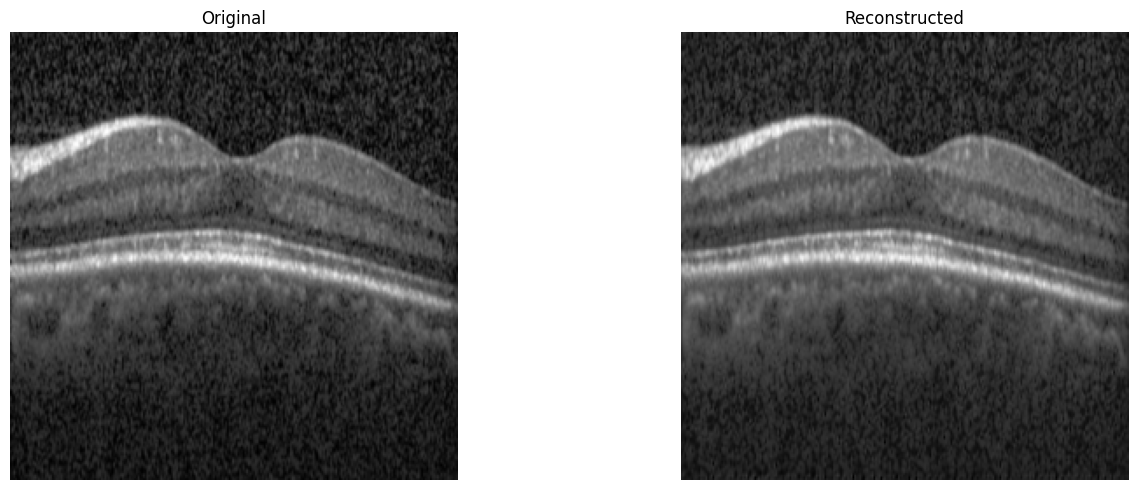

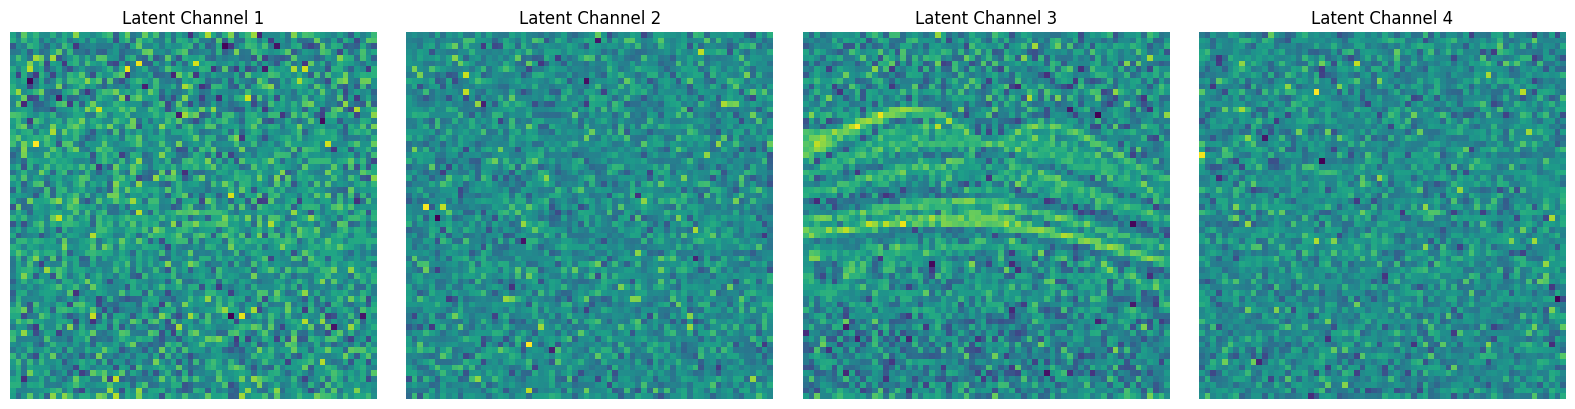

In [6]:
def encode_image(image_tensor):
    """Encode image to latent space using VAE"""
    with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
        z_mu, z_sigma = vae.encode(image_tensor)
        latent = vae.sampling(z_mu, z_sigma)
    return latent, z_mu, z_sigma

def decode_latent(latent):
    """Decode latent back to image using VAE"""
    with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
        reconstructed = vae.decode(latent)
    return reconstructed

def vae_encode_decode_demo(image_path):
    """Demonstrate VAE encoding and decoding"""
    # Load image
    original = load_image(image_path)
    
    # Encode to latent
    latent, z_mu, z_sigma = encode_image(original)
    print(f"Original shape: {original.shape}")
    print(f"Latent shape: {latent.shape}")
    print(f"Latent statistics - Mean: {latent.mean():.4f}, Std: {latent.std():.4f}")
    
    # Decode back to image
    reconstructed = decode_latent(latent)
    
    # Display results
    orig_img = tensor_to_image((original + 1) / 2)  # Denormalize
    recon_img = tensor_to_image((reconstructed + 1) / 2)  # Denormalize
    
    display_images([orig_img, recon_img], ["Original", "Reconstructed"])
    
    # Display latent channels
    latent_np = latent.squeeze().cpu().numpy()
    fig, axes = plt.subplots(1, latent_np.shape[0], figsize=(16, 4))
    for i in range(latent_np.shape[0]):
        axes[i].imshow(latent_np[i], cmap='viridis')
        axes[i].set_title(f'Latent Channel {i+1}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    return original, latent, reconstructed

# Example usage:
original, latent, reconstructed = vae_encode_decode_demo(image_path)

# Cell 5: UNet Generation Functions

Generating from encoded image: /home/mhuber/Thesis/data/KermanyV3_resized/test/3/NORMAL-1569-2.jpeg


100%|███████████████████████████████████████| 2500/2500 [00:33<00:00, 75.21it/s]


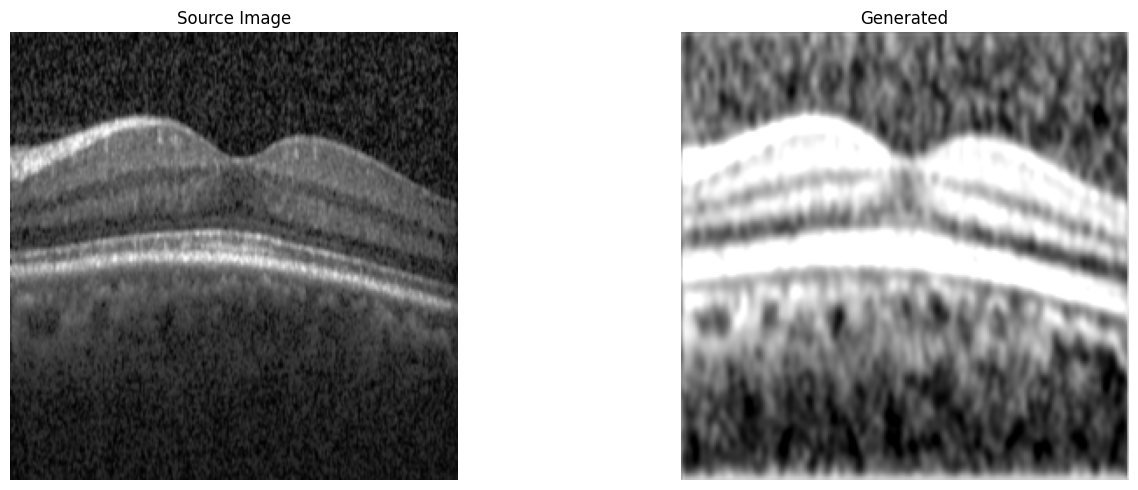

In [7]:
def generate_random_noise(shape=(1, 4, 64, 64)):
    """Generate random noise for diffusion"""
    return torch.randn(shape, device=device, dtype=torch.float32)

def denoise_with_unet(initial_latent, verbose=True):
    """Generate image using UNet from noise"""
    latents = initial_latent.clone().to(dtype=torch.float32)
    timesteps = noise_scheduler.timesteps
    
    progress_iter = tqdm(enumerate(timesteps), total=len(timesteps)) if verbose else enumerate(timesteps)
    
    for i, t in progress_iter:
        current_timestep = torch.tensor([t], device=device)
        
        with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
            noise_pred = unet(x=latents, timesteps=current_timestep)
            latents, _ = noise_scheduler.step(noise_pred, t, latents)#, eta=eta)
        
        del noise_pred
        if i % 50 == 0:
            torch.cuda.empty_cache()
    
    return latents

def unet_generation_demo(use_random_noise=True, source_image_path=None):
    """Demonstrate UNet generation"""
    if use_random_noise:
        print("Generating from random noise...")
        initial_noise = generate_random_noise()
    else:
        print(f"Generating from encoded image: {source_image_path}")
        source_img = load_image(source_image_path)
        latent, _, _ = encode_image(source_img)
        
        # Add noise to the encoded latent
        # noise = torch.randn_like(latent)
        # initial_noise = latent + 0.5 * noise  # Partial noise
        
        initial_noise = latent
    
    # Generate using UNet
    generated_latent = denoise_with_unet(initial_noise)
    
    # Decode to image
    with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
        generated_image = recon_model(generated_latent)
        generated_image = torch.clip(generated_image, -1.0, 1.0)
    
    # Display
    gen_img = tensor_to_image((generated_image + 1) / 2)
    
    if not use_random_noise:
        source_display = tensor_to_image((source_img + 1) / 2)
        display_images([source_display, gen_img], ["Source Image", "Generated"])
    else:
        display_images([gen_img], ["Generated from Random Noise"])
    
    return generated_latent, generated_image

# Example usage:
# generated_latent, generated_image = unet_generation_demo(use_random_noise=True)
generated_latent, generated_image = unet_generation_demo(use_random_noise=False, source_image_path=image_path)

# Cell 6: ControlNet Generation Functions

Generating with ControlNet from encoded image: /home/mhuber/Thesis/data/KermanyV3_resized/test/3/NORMAL-1569-2.jpeg


100%|███████████████████████████████████████| 2500/2500 [00:50<00:00, 49.14it/s]


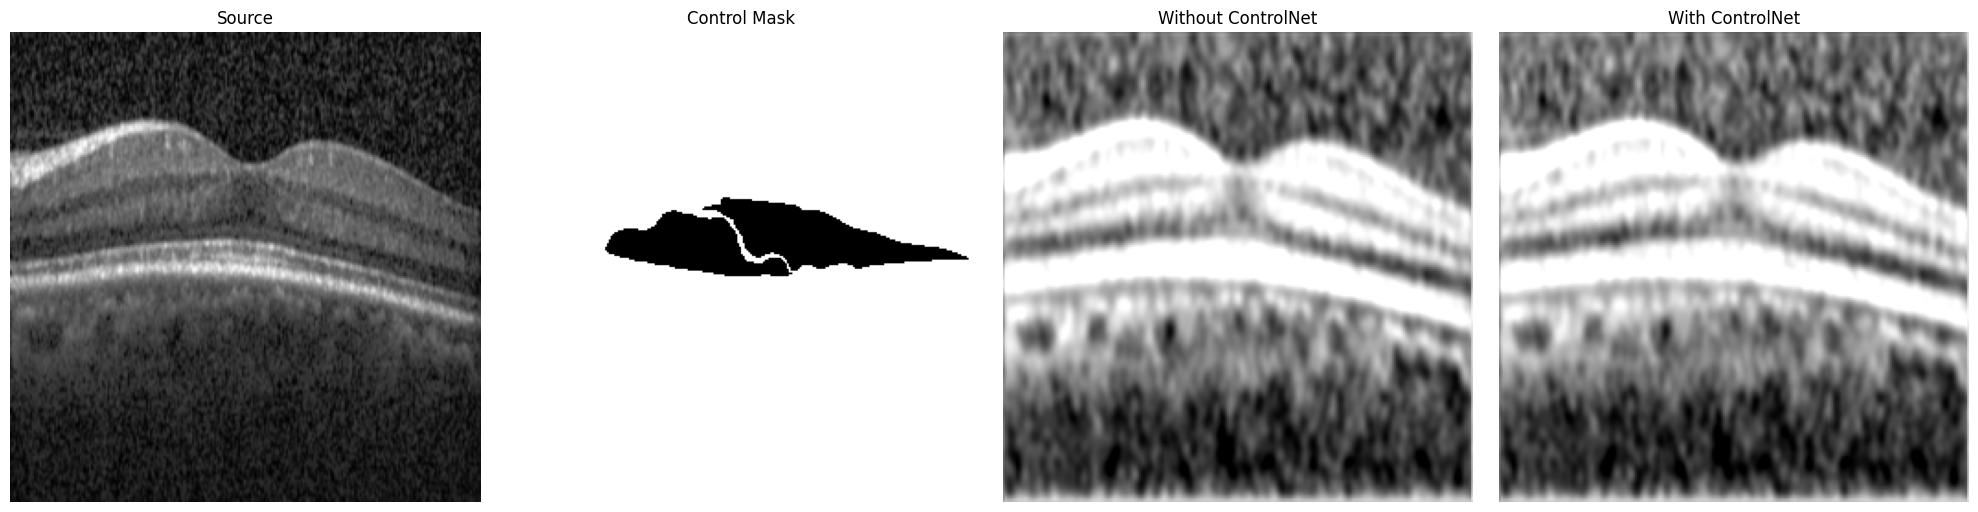

In [8]:
# Cell 6: ControlNet Generation Functions
def denoise_with_controlnet(initial_latent, control_mask, verbose=True):
    """Generate image using ControlNet with mask condition"""
    latents = initial_latent.clone().to(dtype=torch.float32)
    condition = control_mask.to(dtype=torch.float32)
    timesteps = noise_scheduler.timesteps
    
    progress_iter = tqdm(enumerate(timesteps), total=len(timesteps)) if verbose else enumerate(timesteps)
    
    for i, t in progress_iter:
        current_timestep = torch.tensor([t], device=device)
        
        with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
            # ControlNet forward pass
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=latents,
                timesteps=current_timestep,
                controlnet_cond=condition,
            )
            
            # UNet forward pass with ControlNet residuals
            noise_pred = unet(
                x=latents,
                timesteps=current_timestep,
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            
            latents, _ = noise_scheduler.step(noise_pred, t, latents)#, eta=eta)
        
        del noise_pred, down_block_res_samples, mid_block_res_sample
        if i % 50 == 0:
            torch.cuda.empty_cache()
    
    return latents

def controlnet_generation_demo(mask_path, use_random_noise=True, source_image_path=None):
    """Demonstrate ControlNet generation"""
    # Load control mask
    control_mask = load_mask(mask_path)
    mask_display = tensor_to_image(control_mask.squeeze())
    
    if use_random_noise:
        print("Generating with ControlNet from random noise...")
        initial_noise = generate_random_noise()
        source_display = None
    else:
        print(f"Generating with ControlNet from encoded image: {source_image_path}")
        source_img = load_image(source_image_path)
        latent, _, _ = encode_image(source_img)
        # Add noise to the encoded latent
        noise = torch.randn_like(latent)
        initial_noise = latent #+ 0.5 * noise  # Partial noise
        source_display = tensor_to_image((source_img + 1) / 2)
    
    # Generate using ControlNet
    controlled_latent = denoise_with_controlnet(initial_noise, control_mask)
    
    # Also generate without ControlNet for comparison
    uncontrolled_latent = denoise_with_unet(initial_noise.clone(), verbose=False)
    
    # Decode both results
    with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
        controlled_image = recon_model(controlled_latent)
        controlled_image = torch.clip(controlled_image, -1.0, 1.0)
        
        uncontrolled_image = recon_model(uncontrolled_latent)
        uncontrolled_image = torch.clip(uncontrolled_image, -1.0, 1.0)
    
    # Display results
    controlled_img = tensor_to_image((controlled_image + 1) / 2)
    uncontrolled_img = tensor_to_image((uncontrolled_image + 1) / 2)
    
    if source_display is not None:
        display_images(
            [source_display, mask_display, uncontrolled_img, controlled_img],
            ["Source", "Control Mask", "Without ControlNet", "With ControlNet"],
            figsize=(20, 5)
        )
    else:
        display_images(
            [mask_display, uncontrolled_img, controlled_img],
            ["Control Mask", "Without ControlNet", "With ControlNet"],
            figsize=(15, 5)
        )
    
    return controlled_latent, controlled_image, uncontrolled_latent, uncontrolled_image

# Example usage:
# controlled_latent, controlled_image, uncontrolled_latent, uncontrolled_image = controlnet_generation_demo(
#     mask_path="path/to/mask.png", 
#     use_random_noise=True
# )
controlled_latent, controlled_image, uncontrolled_latent, uncontrolled_image = controlnet_generation_demo(
    mask_path=mask_path, 
    use_random_noise=False, 
    source_image_path=image_path
)

In [9]:
# Print current scheduler info
print(f"Scheduler type: {type(noise_scheduler)}")
print(f"Number of timesteps: {len(noise_scheduler.timesteps)}")
print(f"Timesteps: {noise_scheduler.timesteps[:10]}...")  # First 10 steps

Scheduler type: <class 'monai.networks.schedulers.ddim.DDIMScheduler'>
Number of timesteps: 2500
Timesteps: tensor([2499, 2498, 2497, 2496, 2495, 2494, 2493, 2492, 2491, 2490])...


In [10]:
def ddim_invert(latent, timesteps, verbose=True):
    """DDIM inversion to get noise trajectory"""
    x = latent.clone()
    noise_preds = []
    
    progress_iter = tqdm(enumerate(reversed(timesteps)), total=len(timesteps)) if verbose else enumerate(reversed(timesteps))
    
    for i, t in progress_iter:
        current_timestep = torch.tensor([t], device=device)
        
        with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
            # Predict noise
            noise_pred = unet(x=x, timesteps=current_timestep)
            noise_preds.append(noise_pred)
            
            # DDIM forward step
            alpha_t = noise_scheduler.alphas_cumprod[t]
            alpha_prev = noise_scheduler.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0)
            
            # Predict x0
            pred_x0 = (x - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
            
            # Forward step
            x = torch.sqrt(alpha_prev) * pred_x0 + torch.sqrt(1 - alpha_prev) * noise_pred
    
    plot_tensor(x, "Complete Noise")
    
    return x, list(reversed(noise_preds))

############################################################################################
def ddim_invert(latent, timesteps, verbose=True):
    """DDIM inversion to get noise trajectory"""
    x = latent.clone()
    noise_preds = []
    
    progress_iter = tqdm(enumerate(reversed(timesteps)), total=len(timesteps)) if verbose else enumerate(reversed(timesteps))
    
    for i, t in progress_iter:
        current_timestep = torch.tensor([t], device=device)
        
        with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
            # Predict noise - you may need to add conditioning here
            noise_pred = unet(x=x, timesteps=current_timestep)  # Add text_embeds=... if needed
            noise_preds.append(noise_pred)
            
            # DDIM forward step
            alpha_t = noise_scheduler.alphas_cumprod[t]
            
            # Fix alpha_prev calculation
            if i < len(timesteps) - 1:
                t_prev = timesteps[len(timesteps) - 2 - i]  # Next timestep in reverse order
                alpha_prev = noise_scheduler.alphas_cumprod[t_prev]
            else:
                alpha_prev = torch.tensor(1.0, device=device)  # Ensure same device
            
            # Predict x0
            pred_x0 = (x - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
            
            # Forward step
            x = torch.sqrt(alpha_prev) * pred_x0 + torch.sqrt(1 - alpha_prev) * noise_pred
    
    plot_tensor(x, "Complete Noise")
    
    return x, list(reversed(noise_preds))
############################################################################################

def denoise_with_controlnet_ddim(initial_latent, control_mask, stored_noise_preds=None, verbose=True):
    """Generate image using ControlNet with optional stored noise predictions"""
    latents = initial_latent.clone().to(dtype=torch.float32)
    condition = control_mask.to(dtype=torch.float32)
    timesteps = noise_scheduler.timesteps[0:100]
    
    progress_iter = tqdm(enumerate(timesteps), total=len(timesteps)) if verbose else enumerate(timesteps)
    
    for i, t in progress_iter:
        current_timestep = torch.tensor([t], device=device)
        
        with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
            # ControlNet forward pass
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=latents,
                timesteps=current_timestep,
                controlnet_cond=condition,
            )
            
            # UNet forward pass with ControlNet residuals
            noise_pred = unet(
                x=latents,
                timesteps=current_timestep,
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            
            # Optionally blend with stored noise predictions for better reconstruction
            if stored_noise_preds is not None and i < len(stored_noise_preds):
                # Blend original and controlled noise predictions
                blend_factor = 0.3  # Adjust based on how much original structure to preserve
                noise_pred = (1 - blend_factor) * noise_pred + blend_factor * stored_noise_preds[i]
                # noise_pred = blend_factor * stored_noise_preds[i]
            
            latents, _ = noise_scheduler.step(noise_pred, t, latents)#, eta=eta)
        
        del noise_pred, down_block_res_samples, mid_block_res_sample
        if i % 50 == 0:
            torch.cuda.empty_cache()
    
    return latents

def controlnet_generation_demo_ddim(mask_path, use_random_noise=True, source_image_path=None):
    """Demonstrate ControlNet generation with DDIM inversion"""
    # Load control mask
    control_mask = load_mask(mask_path)
    mask_display = tensor_to_image(control_mask.squeeze())
    
    if use_random_noise:
        print("Generating with ControlNet from random noise...")
        initial_noise = generate_random_noise()
        source_display = None
        stored_noise_preds = None
    else:
        print(f"Generating with ControlNet from DDIM inversion: {source_image_path}")
        source_img = load_image(source_image_path)
        latent, _, _ = encode_image(source_img)
        plot_tensor(latent, "Encoding")
        
        # DDIM inversion
        print("Performing DDIM inversion...")
        inverted_noise, stored_noise_preds = ddim_invert(latent, noise_scheduler.timesteps)
        initial_noise = inverted_noise
        #
        gaussian_noise = torch.randn_like(initial_noise)
        blend_factor = 0.5
        initial_noise = (1 - blend_factor) * initial_noise + blend_factor * gaussian_noise
        #
        
        source_display = tensor_to_image((source_img + 1) / 2)
        
    plot_tensor(initial_noise, "Initial Noise")
    
    # Generate using ControlNet
    controlled_latent = denoise_with_controlnet_ddim(
        initial_noise, 
        control_mask, 
        stored_noise_preds=None
    )

    plot_tensor(controlled_latent, "ControlNet output")
    
    # Also generate without ControlNet for comparison
    uncontrolled_latent = denoise_with_unet(initial_noise.clone(), verbose=False)
    
    # Decode both results
    with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
        controlled_image = recon_model(controlled_latent)
        controlled_image = torch.clip(controlled_image, -1.0, 1.0)
        
        uncontrolled_image = recon_model(uncontrolled_latent)
        uncontrolled_image = torch.clip(uncontrolled_image, -1.0, 1.0)
    
    # Display results
    controlled_img = tensor_to_image((controlled_image + 1) / 2)
    uncontrolled_img = tensor_to_image((uncontrolled_image + 1) / 2)
    
    if source_display is not None:
        display_images(
            [source_display, mask_display, uncontrolled_img, controlled_img],
            ["Source", "Control Mask", "DDIM Reconstruction", "With ControlNet"],
            figsize=(20, 5)
        )
    else:
        display_images(
            [mask_display, uncontrolled_img, controlled_img],
            ["Control Mask", "Without ControlNet", "With ControlNet"],
            figsize=(15, 5)
        )
    
    return controlled_latent, controlled_image, uncontrolled_latent, uncontrolled_image, stored_noise_preds

# Example usage:
# controlled_latent, controlled_image, uncontrolled_latent, uncontrolled_image, noise_preds = controlnet_generation_demo_ddim(
#     mask_path=mask_path, 
#     use_random_noise=True, 
#     source_image_path=image_path
# )

In [11]:
# controlled_latent, controlled_image, uncontrolled_latent, uncontrolled_image, noise_preds = controlnet_generation_demo_ddim(
#     mask_path=mask_path, 
#     use_random_noise=True, 
#     source_image_path=image_path
# )

Generating with ControlNet from DDIM inversion: /home/mhuber/Thesis/data/KermanyV3_resized/test/3/NORMAL-1569-2.jpeg


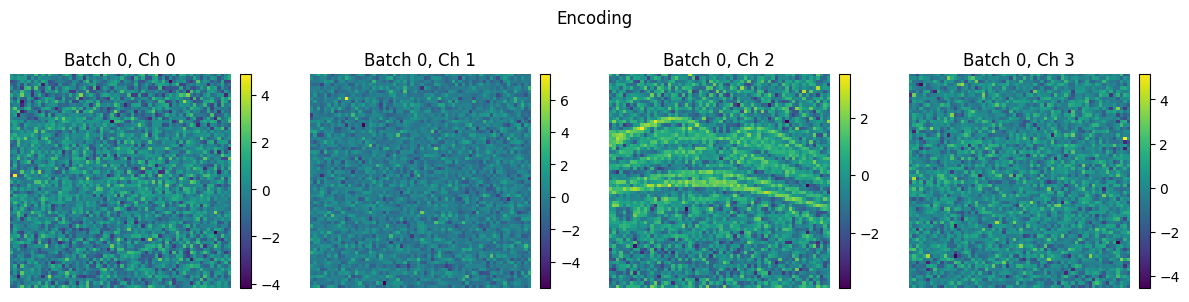

Performing DDIM inversion...


100%|███████████████████████████████████████| 2500/2500 [00:33<00:00, 75.62it/s]


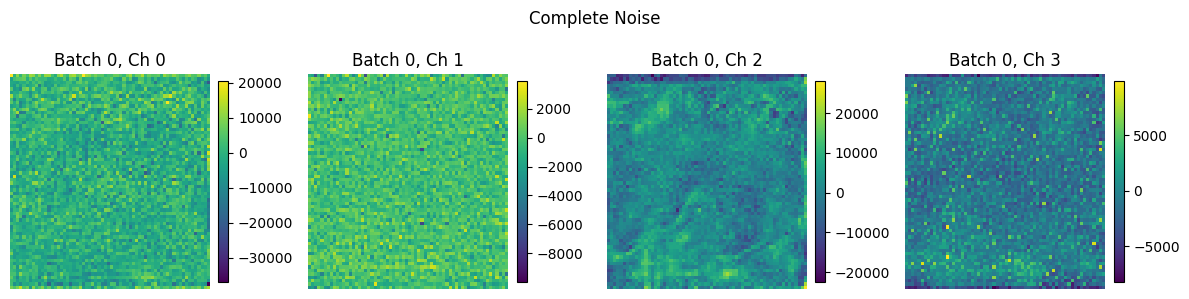

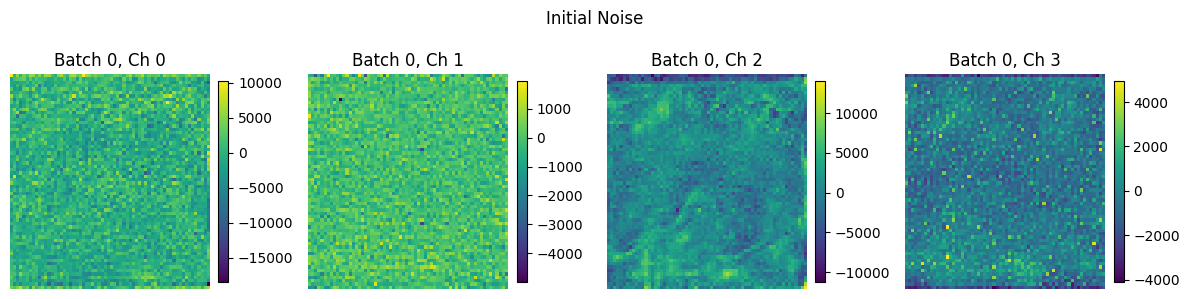

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 38.88it/s]


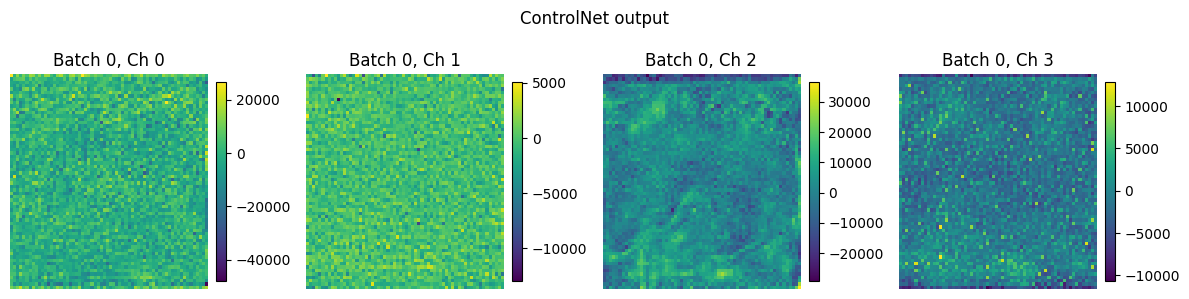

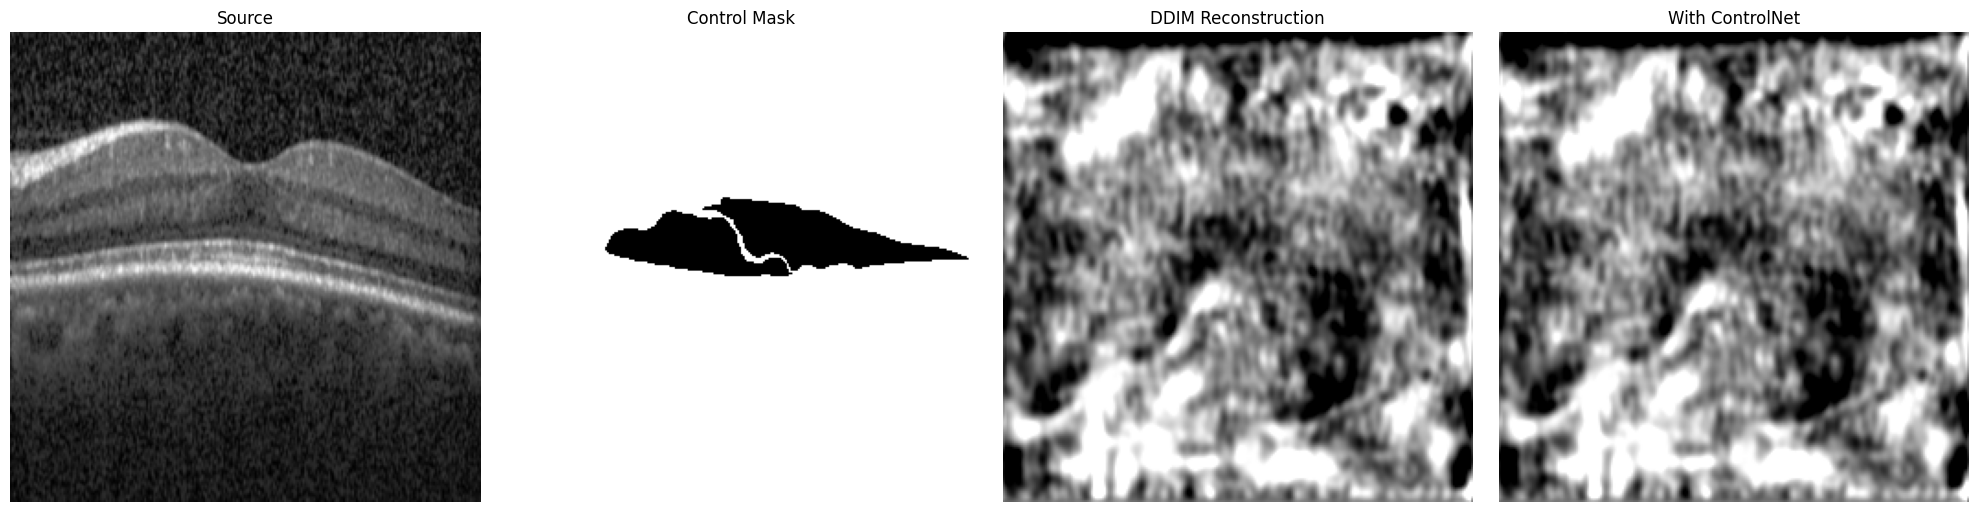

In [12]:
controlled_latent, controlled_image, uncontrolled_latent, uncontrolled_image, noise_preds = controlnet_generation_demo_ddim(
    mask_path=mask_path, 
    use_random_noise=False, 
    source_image_path=image_path
)

# Cell 7: Interactive Experiment Functions

=== Comprehensive Generation Comparison ===

1. VAE Encode-Decode...

2. UNet from random noise...

3. UNet from image latent...

4. ControlNet from random noise...

5. ControlNet from image latent...


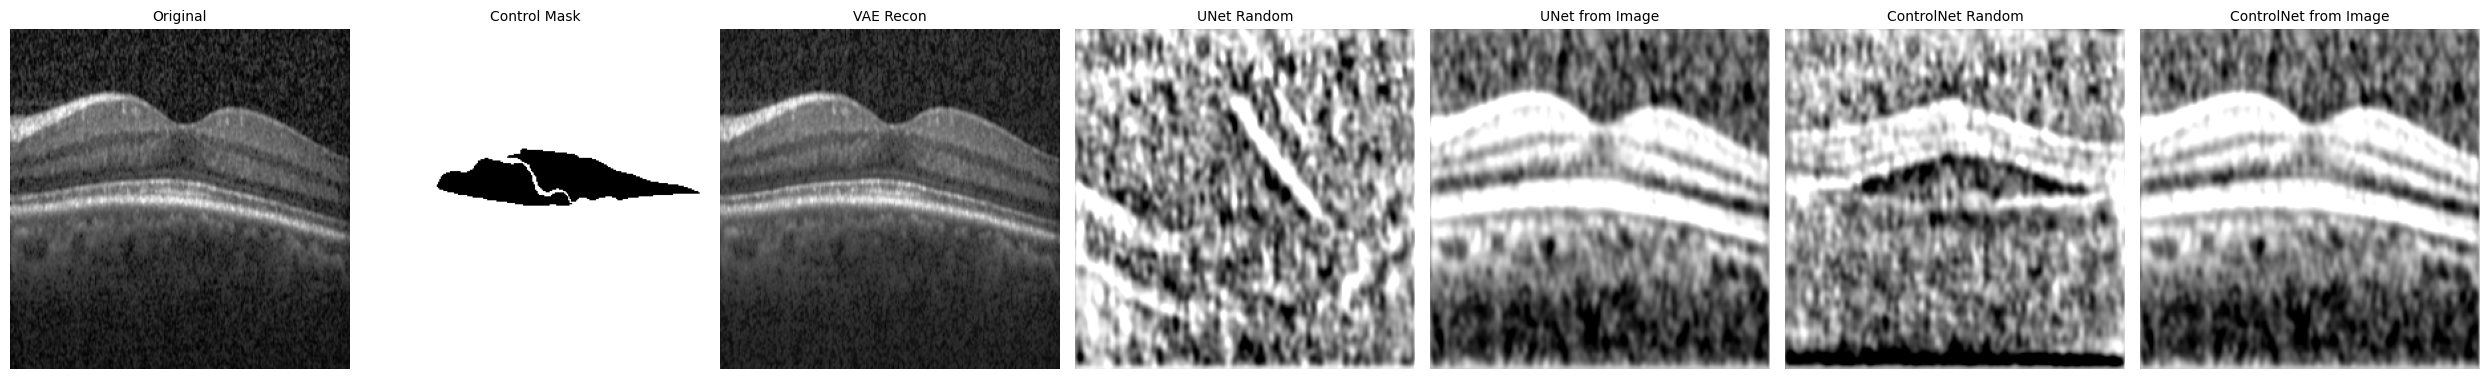

Jupyter notebook cells ready! Use the following functions:
- vae_encode_decode_demo(image_path)
- unet_generation_demo(use_random_noise=True/False, source_image_path=None)
- controlnet_generation_demo(mask_path, use_random_noise=True/False, source_image_path=None)
- compare_generation_methods(image_path, mask_path)


In [13]:
def compare_generation_methods(image_path, mask_path):
    """Compare all generation methods side by side"""
    print("=== Comprehensive Generation Comparison ===")
    
    # Load original image and mask
    original_img = load_image(image_path)
    control_mask = load_mask(mask_path)
    
    # VAE reconstruction
    print("\n1. VAE Encode-Decode...")
    latent, _, _ = encode_image(original_img)
    vae_recon = decode_latent(latent)
    
    # Random noise generation
    print("\n2. UNet from random noise...")
    random_noise = generate_random_noise()
    random_generated_latent = denoise_with_unet(random_noise.clone(), verbose=False)
    
    # Image-conditioned generation
    print("\n3. UNet from image latent...")
    noisy_latent = latent + 0.3 * torch.randn_like(latent)
    image_generated_latent = denoise_with_unet(noisy_latent.clone(), verbose=False)
    
    # ControlNet from random noise
    print("\n4. ControlNet from random noise...")
    controlnet_random_latent = denoise_with_controlnet(random_noise.clone(), control_mask, verbose=False)
    
    # ControlNet from image latent
    print("\n5. ControlNet from image latent...")
    controlnet_image_latent = denoise_with_controlnet(noisy_latent.clone(), control_mask, verbose=False)
    
    # Decode all results
    with torch.no_grad(), autocast(device_type="cuda", dtype=torch.float32):
        results = []
        for latent_result in [latent, random_generated_latent, image_generated_latent, 
                            controlnet_random_latent, controlnet_image_latent]:
            if latent_result is latent:
                decoded = vae_recon  # Already decoded
            else:
                decoded = recon_model(latent_result)
                decoded = torch.clip(decoded, -1.0, 1.0)
            results.append(tensor_to_image((decoded + 1) / 2))
    
    # Display comprehensive comparison
    original_display = tensor_to_image((original_img + 1) / 2)
    mask_display = tensor_to_image(control_mask.squeeze())
    
    all_images = [original_display, mask_display] + results
    titles = ["Original", "Control Mask", "VAE Recon", "UNet Random", "UNet from Image", 
              "ControlNet Random", "ControlNet from Image"]
    
    fig, axes = plt.subplots(1, len(all_images), figsize=(25, 4))
    for img, title, ax in zip(all_images, titles, axes):
        ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example usage:
results = compare_generation_methods(image_path, mask_path)

print("Jupyter notebook cells ready! Use the following functions:")
print("- vae_encode_decode_demo(image_path)")
print("- unet_generation_demo(use_random_noise=True/False, source_image_path=None)")
print("- controlnet_generation_demo(mask_path, use_random_noise=True/False, source_image_path=None)")
print("- compare_generation_methods(image_path, mask_path)")